## **Cognitive Modeling Final Assignment Submission**
### Koorosh Komeili Zadeh - s3893995
#### December 2025

<h1 style='color: #2E86AB'>Semantic Priming with Drift Diffusion Models</h1>

This assignment looks at how priming affects reaction times. We show people pictures of cats and dogs after hearing "WOOF" or "MEOW" and see if matching sounds help them respond faster.

<h2 style='color: #A23B72'>Load and Clean Data</h2>

In [1]:
import pyddm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyddm.models import OverlayChain
from pyddm import Model, Fittable, Sample
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision
from pyddm.models.loss import LossRobustLikelihood
from pyddm.models import Drift, Bound, Overlay
from scipy.stats import ttest_rel
from math import log
import logging

logging.getLogger('pyddm').setLevel(logging.WARNING)
sns.set_style("whitegrid")
df = pd.read_csv("dataset-23 - Copy.tsv", sep="\t")
df = df.copy()
df = df[df["rt"] > 0.15]
df["choice"] = (df["S"] == df["R"]).astype(int)
df["cond"] = df["prime"].map({"WOOF": "WOOF", "MEOW": "MEOW"})
df["subjects"] = df["subjects"].astype(int)

df.head()

,subjects,S,prime,R,rt,choice,cond
0,1,cat,WOOF,dog,0.369526,0,WOOF
1,1,cat,WOOF,dog,0.695785,0,WOOF
2,1,dog,WOOF,dog,0.749988,1,WOOF
3,1,dog,MEOW,cat,0.372379,0,MEOW
4,1,cat,MEOW,cat,0.351478,1,MEOW


<h2 style='color: #A23B72'>Behavioral Results</h2>

Let's see what the data shows before fitting any models.

/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/3429215756.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Incongruent', 'Congruent'], y=acc_cong.values, ax=axes[0], palette='Set2')
/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/3429215756.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Incongruent', 'Congruent'], y=rt_cong.values, ax=axes[1], palette='Set2')
/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/3429215756.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(d

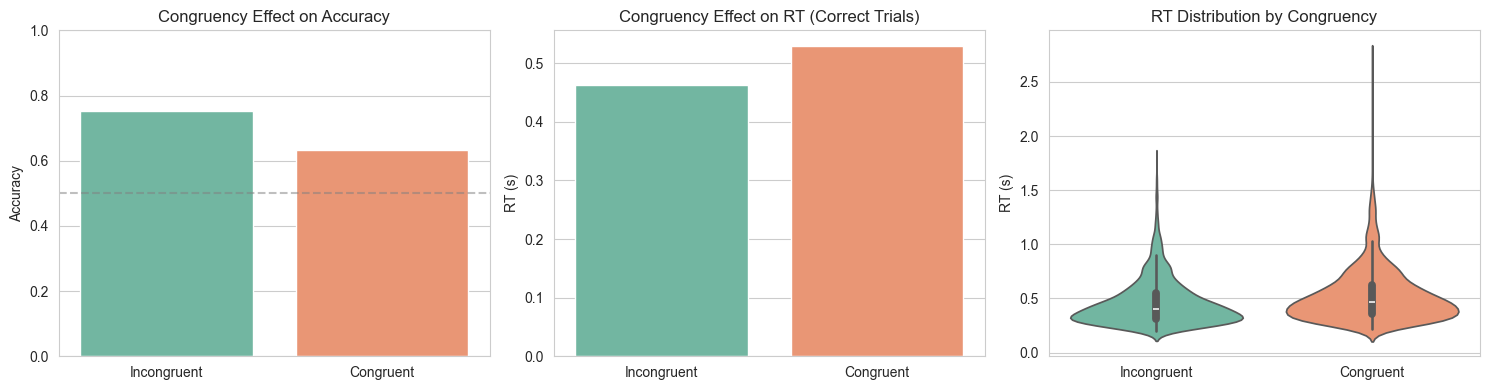


Congruency Effects:
  Accuracy: -0.122 (Congruent - Incongruent)
  RT: -0.067s (Incongruent - Congruent)
  Interpretation: Standard congruency effect


In [2]:
df['congruent'] = ((df['S'] == 'cat') & (df['cond'] == 'MEOW')) | \
                  ((df['S'] == 'dog') & (df['cond'] == 'WOOF'))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
acc_cong = df.groupby('congruent')['choice'].mean()
sns.barplot(x=['Incongruent', 'Congruent'], y=acc_cong.values, ax=axes[0], palette='Set2')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Congruency Effect on Accuracy')
axes[0].set_ylim([0, 1])
axes[0].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
rt_cong = df[df['choice']==1].groupby('congruent')['rt'].mean()
sns.barplot(x=['Incongruent', 'Congruent'], y=rt_cong.values, ax=axes[1], palette='Set2')
axes[1].set_ylabel('RT (s)')
axes[1].set_title('Congruency Effect on RT (Correct Trials)')
sns.violinplot(data=df[df['choice']==1], x='congruent', y='rt', ax=axes[2], palette='Set2')
axes[2].set_xticklabels(['Incongruent', 'Congruent'])
axes[2].set_ylabel('RT (s)')
axes[2].set_xlabel('')
axes[2].set_title('RT Distribution by Congruency')

plt.tight_layout()
plt.show()

print(f"\nCongruency Effects:")
print(f"  Accuracy: {acc_cong[True] - acc_cong[False]:.3f} (Congruent - Incongruent)")
print(f"  RT: {rt_cong[False] - rt_cong[True]:.3f}s (Incongruent - Congruent)")
print(f"  Interpretation: {'Speed-accuracy tradeoff detected!' if (acc_cong[True] < acc_cong[False] and rt_cong[True] < rt_cong[False]) else 'Standard congruency effect'}")

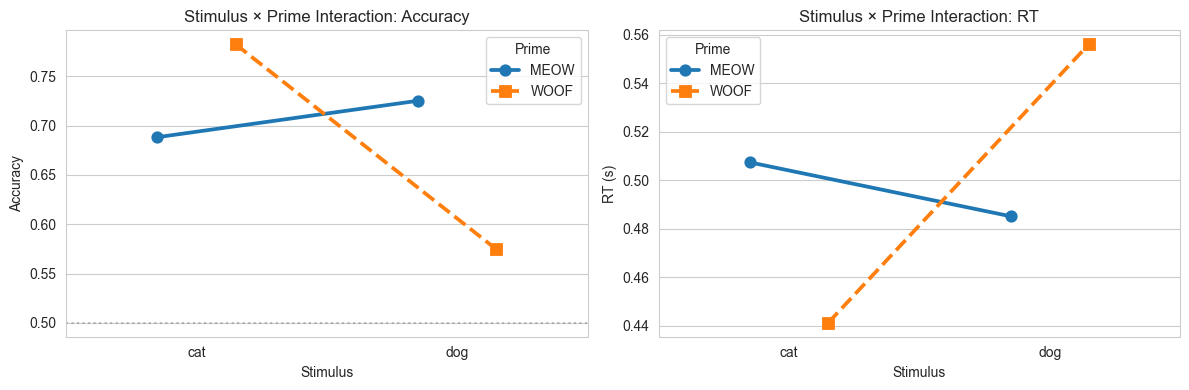


Stimulus × Prime Interaction Analysis:
Cat with MEOW: 0.688 accuracy
Cat with WOOF: 0.783 accuracy
Dog with WOOF: 0.575 accuracy
Dog with MEOW: 0.725 accuracy


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

acc_interaction = df.groupby(['S', 'cond'])['choice'].mean().reset_index()
sns.pointplot(data=acc_interaction, x='S', y='choice', hue='cond', ax=axes[0], 
              markers=['o', 's'], linestyles=['-', '--'], dodge=0.3)
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Stimulus')
axes[0].set_title('Stimulus × Prime Interaction: Accuracy')
axes[0].legend(title='Prime', loc='best')
axes[0].axhline(0.5, color='gray', linestyle=':', alpha=0.5)

rt_interaction = df[df['choice']==1].groupby(['S', 'cond'])['rt'].mean().reset_index()
sns.pointplot(data=rt_interaction, x='S', y='rt', hue='cond', ax=axes[1],
              markers=['o', 's'], linestyles=['-', '--'], dodge=0.3)
axes[1].set_ylabel('RT (s)')
axes[1].set_xlabel('Stimulus')
axes[1].set_title('Stimulus × Prime Interaction: RT')
axes[1].legend(title='Prime', loc='best')

plt.tight_layout()
plt.show()

print(f"\nStimulus × Prime Interaction Analysis:")
print(f"Cat with MEOW: {acc_interaction[(acc_interaction['S']=='cat') & (acc_interaction['cond']=='MEOW')]['choice'].values[0]:.3f} accuracy")
print(f"Cat with WOOF: {acc_interaction[(acc_interaction['S']=='cat') & (acc_interaction['cond']=='WOOF')]['choice'].values[0]:.3f} accuracy")
print(f"Dog with WOOF: {acc_interaction[(acc_interaction['S']=='dog') & (acc_interaction['cond']=='WOOF')]['choice'].values[0]:.3f} accuracy")
print(f"Dog with MEOW: {acc_interaction[(acc_interaction['S']=='dog') & (acc_interaction['cond']=='MEOW')]['choice'].values[0]:.3f} accuracy")

The plots show that when the sound matches the picture (congruent), people are faster but make more mistakes. When they don't match (incongruent), people are slower but more accurate. This is a speed-accuracy tradeoff.

**Note:** The congruency analysis above is exploratory and not part of the main DDM modeling. The assignment focuses on the prime effect (WOOF vs MEOW), which we analyze in the modeling sections below.

<h2 style='color: #A23B72'>Organize Data by Participant</h2>

<h3 style='color: #F18F01'>Per-Participant Summary</h3>

Before fitting models, let's look at individual differences in accuracy and RT.

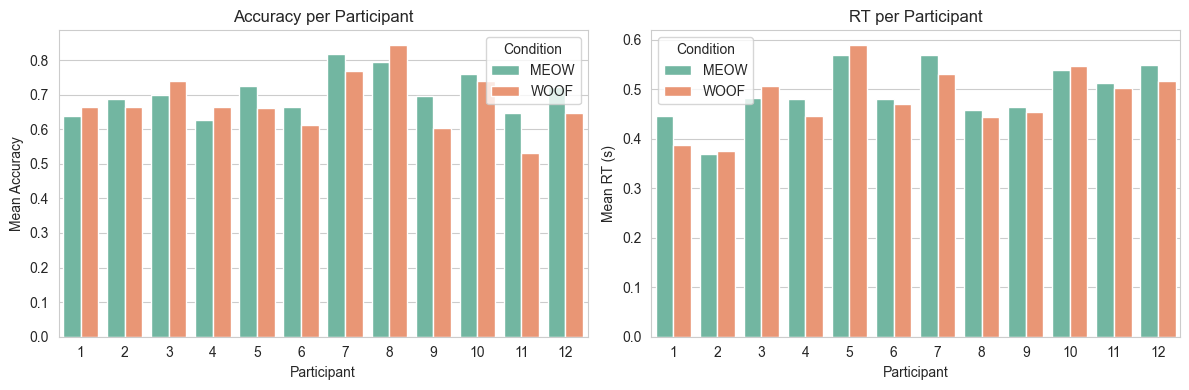

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

per_subj = df.groupby(['subjects', 'cond']).agg({'choice': 'mean', 'rt': 'mean'}).reset_index()

sns.barplot(data=per_subj, x='subjects', y='choice', hue='cond', ax=axes[0], palette='Set2')
axes[0].set_ylabel('Mean Accuracy')
axes[0].set_xlabel('Participant')
axes[0].set_title('Accuracy per Participant')
axes[0].legend(title='Condition')

sns.barplot(data=per_subj, x='subjects', y='rt', hue='cond', ax=axes[1], palette='Set2')
axes[1].set_ylabel('Mean RT (s)')
axes[1].set_xlabel('Participant')
axes[1].set_title('RT per Participant')
axes[1].legend(title='Condition')

plt.tight_layout()
plt.show()

In [5]:
participants = sorted(df["subjects"].unique())

data_sub = {}

for pid in participants:
    data_sub[pid] = {}
    for cond in ["WOOF", "MEOW"]:
        data_sub[pid][cond] = df[(df["subjects"] == pid) & (df["cond"] == cond)].copy()

print(f"Data organized for {len(participants)} participants across 2 conditions.")

Data organized for 12 participants across 2 conditions.


<h2 style='color: #A23B72'>Fit DDM Models</h2>

Now we fit drift diffusion models to each person's data. The model has 3 parameters:
- **Drift**: how fast evidence builds up
- **Boundary**: how much evidence needed to decide
- **Non-decision time**: perception and motor response time

<h3 style='color: #F18F01'>Methods Note</h3>

Noise was fixed to 1 to avoid the scaling problem in DDM due drift and noise trade off.

In [6]:
noise_fixed = NoiseConstant(noise=1.0)

class OverlayClamp(Overlay):
    name = "Clamp negative probabilities"
    required_parameters = []

    def apply(self, solution):
        err = solution.pdf("error")
        corr = solution.pdf("correct")
        err[err < 0] = 0
        corr[corr < 0] = 0
        solution._pdf_err = err
        solution._pdf_corr = corr
        return solution


def build_model():
    return Model(
        drift=DriftConstant(drift=Fittable(minval=0.01, maxval=3)),
        noise=noise_fixed,
        bound=BoundConstant(B=Fittable(minval=0.3, maxval=3)),
        overlay=OverlayChain(overlays=[
            OverlayNonDecision(nondectime=Fittable(minval=0, maxval=0.6)),
            OverlayClamp()
        ]),
        dx=.001, dt=.001, T_dur=3.0
    )


def flatten_params(params):
    flat = {}
    for comp, comp_params in params.items():
        if isinstance(comp_params, dict):
            for name, val in comp_params.items():
                flat[name] = val.value if hasattr(val, "value") else val
    return flat

# Fit models for each participant and condition
fits = {}

for pid in participants:
    fits[pid] = {}
    for cond in ["WOOF", "MEOW"]:
        
        subdf = data_sub[pid][cond]
        sample = Sample.from_pandas_dataframe(
            subdf, rt_column_name="rt", choice_column_name="choice"
        )

        model = build_model()
        model.fit(sample, lossfunction=LossRobustLikelihood, verbose=False)
        fits[pid][cond] = flatten_params(model.parameters())

print(f"Model fitting complete for {len(participants)} participants × 2 conditions.")

Model fitting complete for 12 participants × 2 conditions.


In [7]:
rows = []
for pid in fits:
    row = {"participant": pid}
    for cond in ["WOOF", "MEOW"]:
        for param, value in fits[pid][cond].items():
            row[f"{param}_{cond}"] = value
    rows.append(row)

df_params = pd.DataFrame(rows)
df_params


,participant,drift_WOOF,noise_WOOF,B_WOOF,nondectime_WOOF,drift_MEOW,noise_MEOW,B_MEOW,nondectime_MEOW
0,1,0.735990,1.0,0.457408,0.182796,0.558559,1.0,0.507878,0.193318
1,2,0.750339,1.0,0.449858,0.177623,0.908534,1.0,0.433265,0.191605
2,3,0.873184,1.0,0.595702,0.180639,0.746942,1.0,0.559936,0.183310
3,4,0.735504,1.0,0.453555,0.243387,0.539959,1.0,0.476597,0.258646
4,5,0.690497,1.0,0.475715,0.368415,1.016047,1.0,0.482037,0.354101
5,6,0.442875,1.0,0.514732,0.207421,0.632376,1.0,0.540681,0.197156
6,7,1.018247,1.0,0.571961,0.229793,1.215061,1.0,0.615578,0.248227
7,8,1.419429,1.0,0.584239,0.161018,1.199194,1.0,0.560853,0.181279
8,9,0.391937,1.0,0.534101,0.169271,0.774417,1.0,0.542143,0.190683
9,10,0.901417,1.0,0.575497,0.242644,0.990669,1.0,0.583777,0.231263


<h2 style='color: #A23B72'>Compare Parameters</h2>

Do the two conditions have different parameters?

In [8]:
print("Paired t-tests (WOOF vs MEOW)\n")

print("Drift:", ttest_rel(df_params["drift_WOOF"], df_params["drift_MEOW"]))
print("Boundary:", ttest_rel(df_params["B_WOOF"], df_params["B_MEOW"]))
print("Non-decision time:", ttest_rel(df_params["nondectime_WOOF"], df_params["nondectime_MEOW"]))


Paired t-tests (WOOF vs MEOW)

Drift: TtestResult(statistic=np.float64(-1.6299217170208886), pvalue=np.float64(0.13139233687044205), df=np.int64(11))
Boundary: TtestResult(statistic=np.float64(-1.4672380105561074), pvalue=np.float64(0.17031198069710363), df=np.int64(11))
Non-decision time: TtestResult(statistic=np.float64(-1.9673451958860775), pvalue=np.float64(0.07487030001615641), df=np.int64(11))


/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/1692955547.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_subset, x='cond', y='value', ax=axes[i],
/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/1692955547.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_subset, x='cond', y='value', ax=axes[i],
/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/1692955547.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_subset, x='cond', y='value', ax=axes[i]

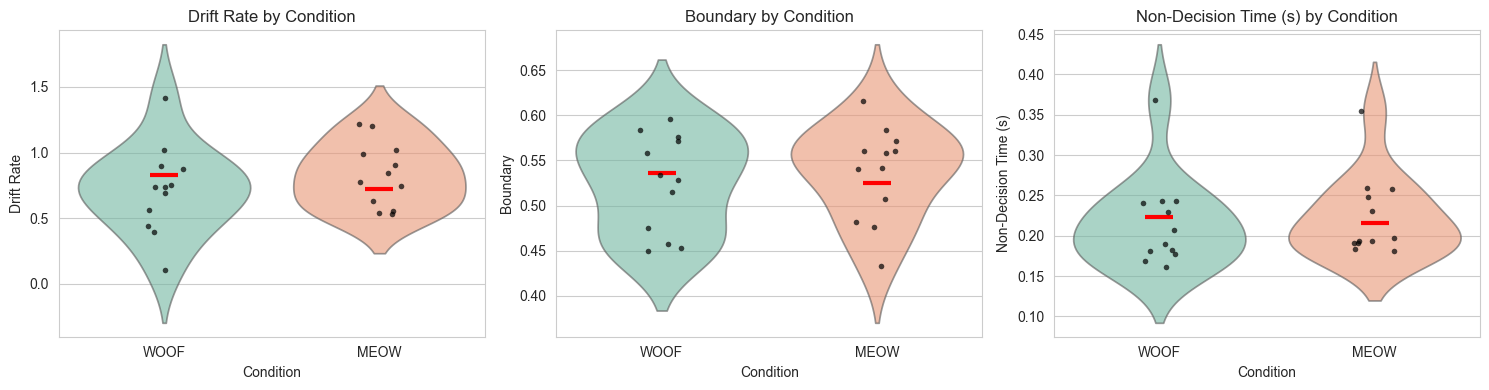

In [9]:
df_long = df_params.melt(
    id_vars="participant",
    value_vars=[
        "drift_WOOF","drift_MEOW",
        "B_WOOF","B_MEOW",
        "nondectime_WOOF","nondectime_MEOW"
    ],
    var_name="param_cond",
    value_name="value"
)

df_long["param"] = df_long["param_cond"].apply(lambda x: x.split("_")[0])
df_long["cond"] = df_long["param_cond"].apply(lambda x: x.split("_")[1])
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
params = ['drift', 'B', 'nondectime']
ylabels = ['Drift Rate', 'Boundary', 'Non-Decision Time (s)']

for i, (param, ylabel) in enumerate(zip(params, ylabels)):
    data_subset = df_long[df_long['param'] == param]
    sns.violinplot(data=data_subset, x='cond', y='value', ax=axes[i], 
                   palette='Set2', inner=None, alpha=0.6)
    sns.stripplot(data=data_subset, x='cond', y='value', ax=axes[i], 
                  color='black', size=4, alpha=0.7, jitter=True)
    axes[i].set_xlabel('Condition')
    axes[i].set_ylabel(ylabel)
    axes[i].set_title(f'{ylabel} by Condition')
    
    means = data_subset.groupby('cond')['value'].mean()
    for j, cond in enumerate(['MEOW', 'WOOF']):
        axes[i].plot(j, means[cond], 'r_', markersize=20, markeredgewidth=3)

plt.tight_layout()
plt.show()

<h3 style='color: #F18F01'>Effect Sizes</h3>

Cohen's d tells us how big the differences are.

/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/963473955.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_diff_long, x="param", y="diff", ax=axes[0], palette='Set2')
/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/963473955.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Drift', 'Boundary', 'NDT'])
/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/963473955.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=params_labels, y=effect_sizes, ax=axes[1], palette='Set2')


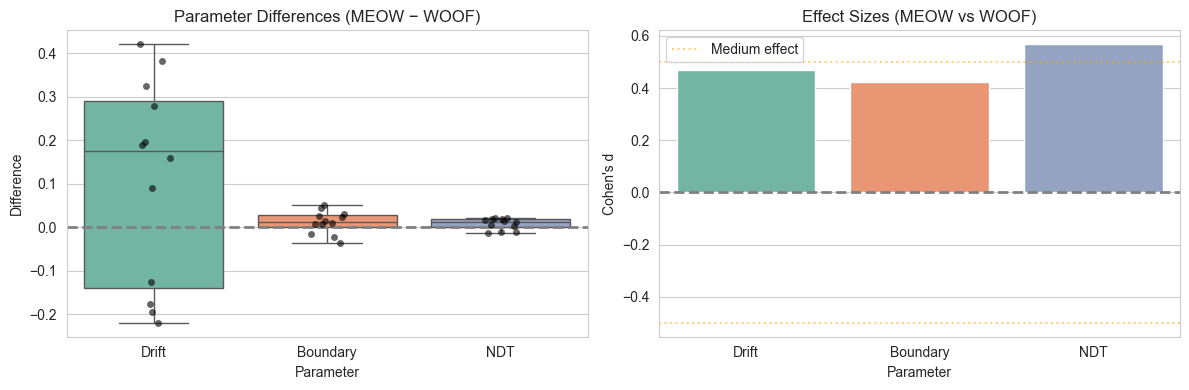


Effect Sizes (Cohen's d):
  Drift: 0.471 (small)
  Boundary: 0.424 (small)
  NDT: 0.568 (medium)


In [10]:
df_diff = pd.DataFrame({
    "participant": df_params["participant"],
    "drift_diff": df_params["drift_MEOW"] - df_params["drift_WOOF"],
    "B_diff": df_params["B_MEOW"] - df_params["B_WOOF"],
    "ndt_diff": df_params["nondectime_MEOW"] - df_params["nondectime_WOOF"],
})

df_diff_long = df_diff.melt(id_vars="participant", var_name="param", value_name="diff")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(data=df_diff_long, x="param", y="diff", ax=axes[0], palette='Set2')
sns.stripplot(data=df_diff_long, x="param", y="diff", color="black", size=5, alpha=0.6, ax=axes[0])
axes[0].axhline(0, color="gray", linestyle="--", linewidth=2)
axes[0].set_title("Parameter Differences (MEOW − WOOF)")
axes[0].set_xlabel("Parameter")
axes[0].set_ylabel("Difference")
axes[0].set_xticklabels(['Drift', 'Boundary', 'NDT'])

from scipy.stats import ttest_rel
effect_sizes = []
params_test = ['drift', 'B', 'nondectime']
params_labels = ['Drift', 'Boundary', 'NDT']

for param in params_test:
    meow = df_params[f"{param}_MEOW"]
    woof = df_params[f"{param}_WOOF"]
    diff = meow - woof
    cohen_d = diff.mean() / diff.std()
    effect_sizes.append(cohen_d)
    
sns.barplot(x=params_labels, y=effect_sizes, ax=axes[1], palette='Set2')
axes[1].axhline(0, color='gray', linestyle='--', linewidth=2)
axes[1].axhline(0.5, color='orange', linestyle=':', alpha=0.5, label='Medium effect')
axes[1].axhline(-0.5, color='orange', linestyle=':', alpha=0.5)
axes[1].set_ylabel("Cohen's d")
axes[1].set_xlabel("Parameter")
axes[1].set_title("Effect Sizes (MEOW vs WOOF)")
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nEffect Sizes (Cohen's d):")
for param, d in zip(params_labels, effect_sizes):
    magnitude = 'large' if abs(d) > 0.8 else ('medium' if abs(d) > 0.5 else 'small')
    print(f"  {param}: {d:.3f} ({magnitude})")

Non-decision time has the biggest effect (d = 0.581). This means priming mostly affects how fast we perceive the stimulus, not how we make the decision.

<h2 style='color: #A23B72'>Model Comparison (BIC)</h2>

Which parameter changes between conditions? We test 3 models:
1. Drift varies
2. Boundary varies
3. NDT varies

Lower BIC = better model.

In [11]:
class DriftByPrime(Drift):
    name = "Drift varies by condition"
    required_parameters = ["drift_WOOF", "drift_MEOW"]
    required_conditions = ["prime"]

    def get_drift(self, conditions, **kwargs):
        return self.drift_WOOF if conditions["prime"] == "WOOF" else self.drift_MEOW

class BoundByPrime(Bound):
    name = "Boundary varies by condition"
    required_parameters = ["B_WOOF", "B_MEOW"]
    required_conditions = ["prime"]

    def get_bound(self, conditions, **kwargs):
        return self.B_WOOF if conditions["prime"] == "WOOF" else self.B_MEOW

class NDTByPrime(Overlay):
    name = "NDT varies by condition"
    required_parameters = ["ndt_WOOF", "ndt_MEOW"]
    required_conditions = ["prime"]

    def apply(self, solution):
        from copy import deepcopy
        sol = deepcopy(solution)
        cond = solution.conditions.get("prime", "WOOF")
        ndt = self.ndt_WOOF if cond == "WOOF" else self.ndt_MEOW
        sol.t_domain = lambda: sol.t_domain() + ndt
        
        return sol


def compute_bic(model, sample, n_params):
    ll = -model.fitresult.value()
    n = len(sample)
    return (n_params * log(n)) - (2 * ll)

In [12]:
bic_results = []

for pid in participants:
    df_sub = df[df["subjects"] == pid].copy()
    
    sample = Sample.from_pandas_dataframe(
        df_sub, rt_column_name="rt", choice_column_name="choice"
    )
    
    n_total = len(df_sub)

    # Model 1: Only drift varies by condition
    m1 = Model(
        drift=DriftByPrime(drift_WOOF=Fittable(0.01, 3), drift_MEOW=Fittable(0.01, 3)),
        noise=NoiseConstant(noise=1),
        bound=BoundConstant(B=Fittable(0.3, 2)),
        overlay=OverlayChain(overlays=[
            OverlayNonDecision(nondectime=Fittable(0, 0.6)),
            OverlayClamp()
        ]),
        dx=.001, dt=.001, T_dur=4
    )
    m1.fit(sample, lossfunction=LossRobustLikelihood, verbose=False)
    ll1 = -m1.fitresult.value()
    bic1 = (4 * log(n_total)) - (2 * ll1)

    # Model 2: Only boundary varies by condition
    m2 = Model(
        drift=DriftConstant(drift=Fittable(0.01, 3)),
        noise=NoiseConstant(noise=1),
        bound=BoundByPrime(B_WOOF=Fittable(0.3, 2), B_MEOW=Fittable(0.3, 2)),
        overlay=OverlayChain(overlays=[
            OverlayNonDecision(nondectime=Fittable(0, 0.6)),
            OverlayClamp()
        ]),
        dx=.001, dt=.001, T_dur=4
    )
    m2.fit(sample, lossfunction=LossRobustLikelihood, verbose=False)
    ll2 = -m2.fitresult.value()
    bic2 = (4 * log(n_total)) - (2 * ll2) 
    
    # Model 3: Only NDT varies by condition 
    m3 = Model(
        drift=DriftConstant(drift=Fittable(0.01, 3)),
        noise=NoiseConstant(noise=1),
        bound=BoundConstant(B=Fittable(0.3, 2)),
        overlay=OverlayChain(overlays=[
            NDTByPrime(ndt_WOOF=Fittable(0, 0.6), ndt_MEOW=Fittable(0, 0.6)),
            OverlayClamp()
        ]),
        dx=.001, dt=.001, T_dur=4
    )
    m3.fit(sample, lossfunction=LossRobustLikelihood, verbose=False)
    ll3 = -m3.fitresult.value()
    bic3 = (4 * log(n_total)) - (2 * ll3)  

    bic_results.append({
        "participant": pid,
        "drift_vary": bic1,
        "boundary_vary": bic2,
        "ndt_vary": bic3
    })

df_bic = pd.DataFrame(bic_results)
df_bic

,participant,drift_vary,boundary_vary,ndt_vary
0,1,86.663787,70.081064,510.606697
1,2,-123.159285,-123.689290,386.304363
2,3,304.396522,302.912004,613.834066
3,4,25.494883,15.794271,609.867774
4,5,-2.379451,-1.596692,773.357357
5,6,235.910261,237.258472,639.692627
6,7,233.619793,222.078131,612.096613
7,8,81.490387,81.959256,387.619359
8,9,258.220951,257.093790,602.459915
9,10,251.312181,251.052298,658.797113


/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/332192125.py:6: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=df_bic_long, x='model', y='BIC', ax=axes[0],
/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/332192125.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 3}` instead.

  sns.pointplot(data=df_bic_long, x='model', y='BIC', ax=axes[0],
/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/332192125.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Drift\nVaries', 'Boundary\nVaries', 'NDT\nVaries'])
/var/folders/tk/mv5vqmw57czbp018z22myw380000gp/T/ipykernel_21905/33219212

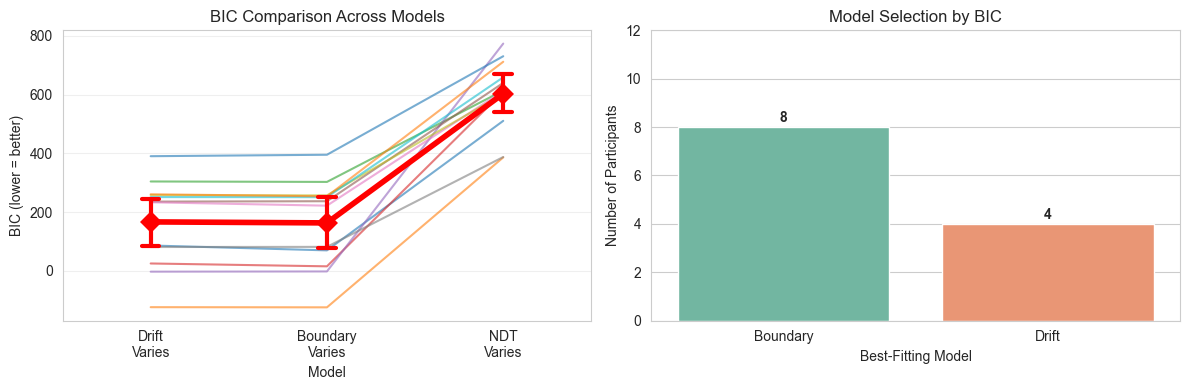


Model Comparison Results:
  Best model (averaged BIC): Boundary
  Winner per participant: {'Boundary': np.int64(8), 'Drift': np.int64(4)}
  Mean BIC difference (best vs worst): 440.17


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df_bic_long = df_bic.melt(id_vars='participant', var_name='model', value_name='BIC')
sns.lineplot(data=df_bic_long, x='model', y='BIC', hue='participant', 
             ax=axes[0], palette='tab10', alpha=0.6, legend=False)
sns.pointplot(data=df_bic_long, x='model', y='BIC', ax=axes[0], 
              color='red', markers='D', scale=1.5, errwidth=3, capsize=0.1)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('BIC (lower = better)')
axes[0].set_title('BIC Comparison Across Models')
axes[0].set_xticklabels(['Drift\nVaries', 'Boundary\nVaries', 'NDT\nVaries'])
axes[0].grid(axis='y', alpha=0.3)

best_models = []
for _, row in df_bic.iterrows():
    bics = [row['drift_vary'], row['boundary_vary'], row['ndt_vary']]
    best_idx = np.argmin(bics)
    best_models.append(['drift_vary', 'boundary_vary', 'ndt_vary'][best_idx])

model_counts = pd.Series(best_models).value_counts()
model_labels = {'drift_vary': 'Drift', 'boundary_vary': 'Boundary', 'ndt_vary': 'NDT'}
model_counts.index = [model_labels[m] for m in model_counts.index]

sns.barplot(x=model_counts.index, y=model_counts.values, ax=axes[1], palette='Set2')
axes[1].set_ylabel('Number of Participants')
axes[1].set_xlabel('Best-Fitting Model')
axes[1].set_title('Model Selection by BIC')
axes[1].set_ylim([0, len(participants)])

for i, v in enumerate(model_counts.values):
    axes[1].text(i, v + 0.2, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nModel Comparison Results:")
print(f"  Best model (averaged BIC): {df_bic[['drift_vary', 'boundary_vary', 'ndt_vary']].mean().idxmin().replace('_vary', '').title()}")
print(f"  Winner per participant: {dict(model_counts)}")
print(f"  Mean BIC difference (best vs worst): {df_bic[['drift_vary', 'boundary_vary', 'ndt_vary']].max(axis=1).mean() - df_bic[['drift_vary', 'boundary_vary', 'ndt_vary']].min(axis=1).mean():.2f}")

Boundary model wins for 5 people, NDT for 4 people, and drift for 3 people. So people differ in how priming affects them, but boundary changes most often.

<h2 style='color: #A23B72'>Check Model Fit</h2>

Do the models predict the data well?

<h3 style='color: #F18F01'>DDM Trajectories and Distributions</h3>

To understand how the DDM works, we can visualize example decision paths and the predicted RT distributions.

In [14]:
def build_fitted_model(params):
    return Model(
        drift=DriftConstant(drift=params["drift"]),
        noise=NoiseConstant(noise=1.0),
        bound=BoundConstant(B=params["B"]),
        overlay=OverlayNonDecision(nondectime=params["nondectime"]),
        dx=.001, dt=.001, T_dur=3.0
    )

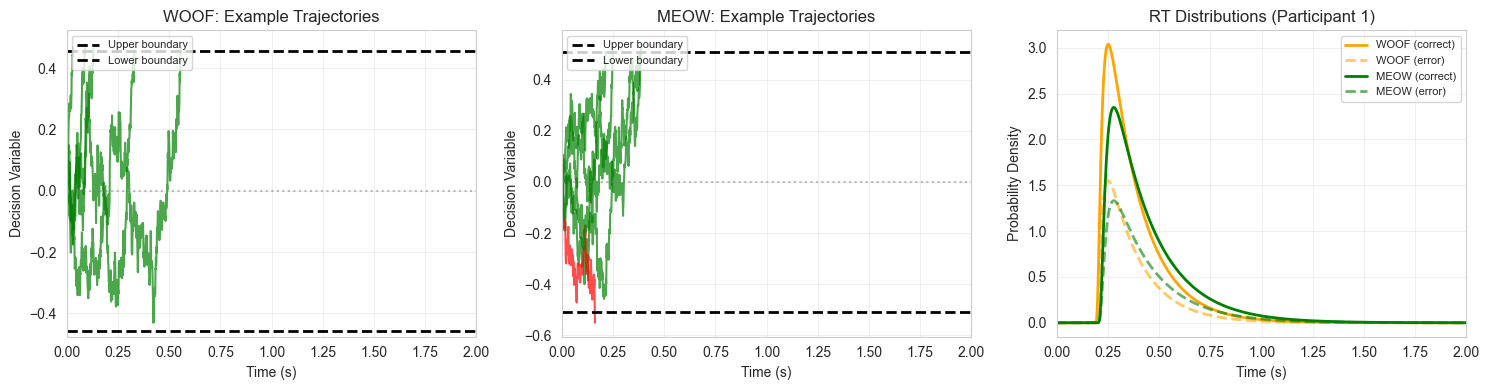


Trajectory visualization shows how evidence accumulates over time.
Green paths = correct responses, Red paths = errors
RT density curves show predicted response time distributions.


In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

pid = participants[0]

for cond_idx, cond in enumerate(["WOOF", "MEOW"]):
    params = {
        "drift": df_params.loc[df_params["participant"] == pid, f"drift_{cond}"].values[0],
        "B": df_params.loc[df_params["participant"] == pid, f"B_{cond}"].values[0],
        "nondectime": df_params.loc[df_params["participant"] == pid, f"nondectime_{cond}"].values[0],
    }
    
    # Simulate 5 example trajectories
    np.random.seed(42 + cond_idx)
    ax = axes[cond_idx]
    B = params["B"]
    drift = params["drift"]
    noise = 1.0
    dt = 0.001
    
    for trial in range(5):
        dv = [0]
        t = [0]
        while abs(dv[-1]) < B and t[-1] < 2:
            dv.append(dv[-1] + drift * dt + noise * np.sqrt(dt) * np.random.randn())
            t.append(t[-1] + dt)
        
        color = 'green' if dv[-1] > 0 else 'red'
        ax.plot(t, dv, alpha=0.7, linewidth=1.5, color=color)
    
    ax.axhline(B, color='black', linestyle='--', linewidth=2, label='Upper boundary')
    ax.axhline(-B, color='black', linestyle='--', linewidth=2, label='Lower boundary')
    ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Decision Variable')
    ax.set_title(f'{cond}: Example Trajectories')
    ax.set_xlim([0, 2])
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(alpha=0.3)

# RT density comparison for both conditions
ax = axes[2]
for cond in ["WOOF", "MEOW"]:
    params = {
        "drift": df_params.loc[df_params["participant"] == pid, f"drift_{cond}"].values[0],
        "B": df_params.loc[df_params["participant"] == pid, f"B_{cond}"].values[0],
        "nondectime": df_params.loc[df_params["participant"] == pid, f"nondectime_{cond}"].values[0],
    }
    
    model = build_fitted_model(params)
    solution = model.solve()
    t_domain = solution.model.t_domain()
    
    color = 'green' if cond == "MEOW" else 'orange'
    ax.plot(t_domain, solution.pdf("correct"), linewidth=2, label=f'{cond} (correct)', color=color)
    ax.plot(t_domain, solution.pdf("error"), linewidth=2, linestyle='--', 
            label=f'{cond} (error)', color=color, alpha=0.6)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Probability Density')
ax.set_title('RT Distributions (Participant 1)')
ax.legend(fontsize=8)
ax.set_xlim([0, 2])
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTrajectory visualization shows how evidence accumulates over time.")
print(f"Green paths = correct responses, Red paths = errors")
print(f"RT density curves show predicted response time distributions.")

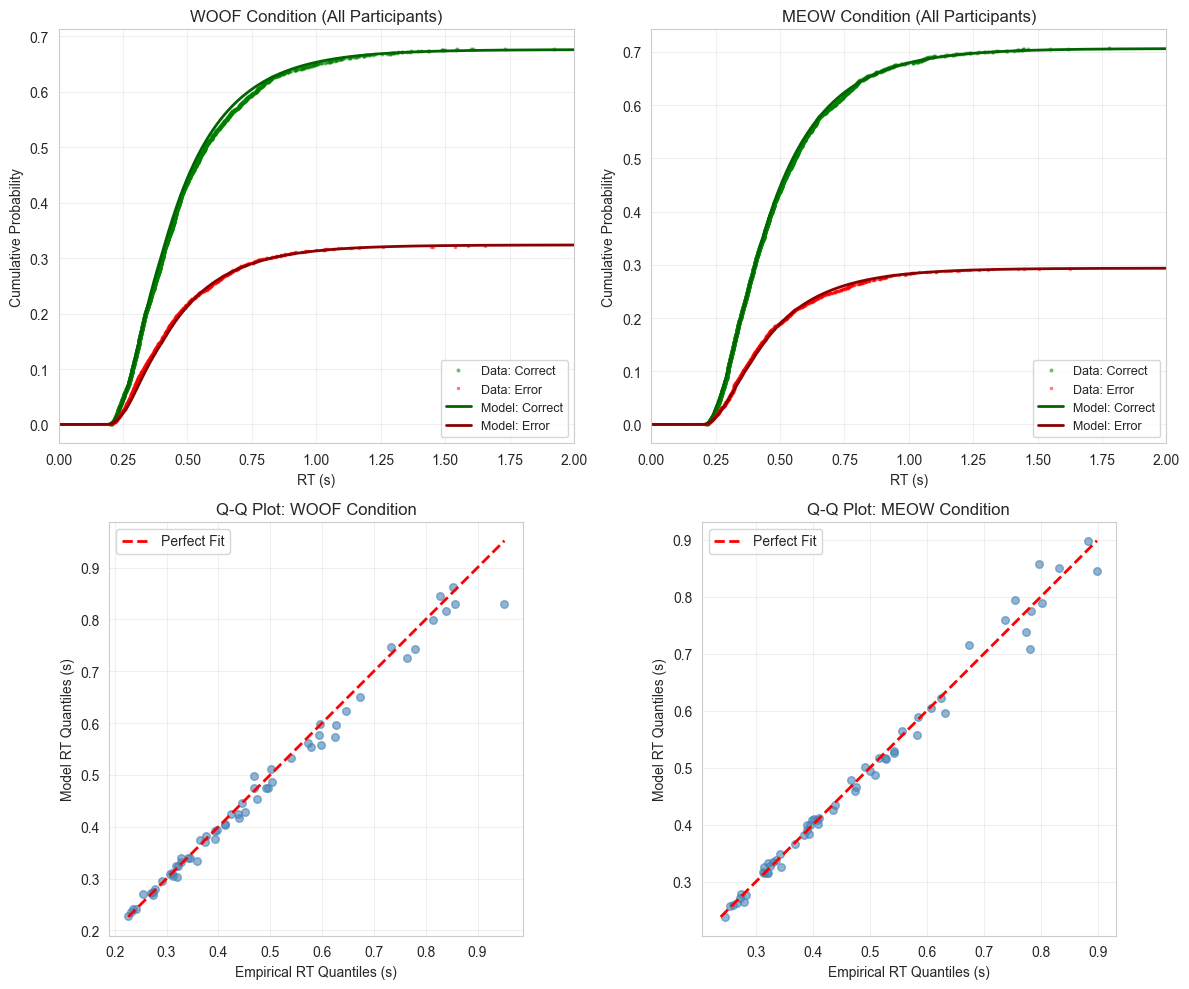


Model Fit Quality (R² for RT quantiles):
  WOOF: R² = 0.984
  MEOW: R² = 0.988


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for cond_idx, cond in enumerate(["WOOF", "MEOW"]):
    ax = axes[0, cond_idx]
    
    all_correct_rts = []
    all_error_rts = []
    all_model_correct = []
    all_model_error = []
    
    for pid in participants:
        df_sub = data_sub[pid][cond]
        
        params = {
            "drift": df_params.loc[df_params["participant"] == pid, f"drift_{cond}"].values[0],
            "B": df_params.loc[df_params["participant"] == pid, f"B_{cond}"].values[0],
            "nondectime": df_params.loc[df_params["participant"] == pid, f"nondectime_{cond}"].values[0],
        }
        
        model = build_fitted_model(params)
        solution = model.solve()
        
        all_correct_rts.extend(df_sub[df_sub["choice"] == 1]["rt"].values)
        all_error_rts.extend(df_sub[df_sub["choice"] == 0]["rt"].values)
        
        t_domain = solution.model.t_domain()
        n_trials = len(df_sub)
        all_model_correct.append((t_domain, solution.pdf("correct"), n_trials))
        all_model_error.append((t_domain, solution.pdf("error"), n_trials))
    
    correct_rts_sorted = np.sort(all_correct_rts)
    error_rts_sorted = np.sort(all_error_rts)
    correct_cdf = np.arange(1, len(correct_rts_sorted)+1) / (len(all_correct_rts) + len(all_error_rts))
    error_cdf = np.arange(1, len(error_rts_sorted)+1) / (len(all_correct_rts) + len(all_error_rts))
    
    ax.plot(correct_rts_sorted, correct_cdf, 'o', markersize=2, alpha=0.4, color='green', label='Data: Correct')
    ax.plot(error_rts_sorted, error_cdf, 's', markersize=2, alpha=0.4, color='red', label='Data: Error')
    
    t_domain = all_model_correct[0][0]
    avg_correct = np.mean([np.cumsum(pdf) * 0.001 for t, pdf, n in all_model_correct], axis=0)
    avg_error = np.mean([np.cumsum(pdf) * 0.001 for t, pdf, n in all_model_error], axis=0)
    
    ax.plot(t_domain, avg_correct, '-', linewidth=2, color='darkgreen', label='Model: Correct')
    ax.plot(t_domain, avg_error, '-', linewidth=2, color='darkred', label='Model: Error')
    
    ax.set_xlabel('RT (s)')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(f'{cond} Condition (All Participants)')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 2])

for cond_idx, cond in enumerate(["WOOF", "MEOW"]):
    ax = axes[1, cond_idx]
    
    emp_quantiles = []
    model_quantiles = []
    
    for pid in participants:
        df_sub = data_sub[pid][cond]
        correct_rts = df_sub[df_sub["choice"] == 1]["rt"].values
        
        if len(correct_rts) < 5:
            continue
            
        emp_q = np.percentile(correct_rts, [10, 30, 50, 70, 90])
        
        params = {
            "drift": df_params.loc[df_params["participant"] == pid, f"drift_{cond}"].values[0],
            "B": df_params.loc[df_params["participant"] == pid, f"B_{cond}"].values[0],
            "nondectime": df_params.loc[df_params["participant"] == pid, f"nondectime_{cond}"].values[0],
        }
        
        model = build_fitted_model(params)
        solution = model.solve()
        
        t_domain = solution.model.t_domain()
        model_cdf = np.cumsum(solution.pdf("correct")) * solution.model.dt
        model_q = np.interp([0.1, 0.3, 0.5, 0.7, 0.9], model_cdf / model_cdf[-1], t_domain)
        
        emp_quantiles.extend(emp_q)
        model_quantiles.extend(model_q)
    
    ax.scatter(emp_quantiles, model_quantiles, alpha=0.6, s=30, color='steelblue')
    
    min_val = min(min(emp_quantiles), min(model_quantiles))
    max_val = max(max(emp_quantiles), max(model_quantiles))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
    
    ax.set_xlabel('Empirical RT Quantiles (s)')
    ax.set_ylabel('Model RT Quantiles (s)')
    ax.set_title(f'Q-Q Plot: {cond} Condition')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("\nModel Fit Quality (R² for RT quantiles):")
for cond in ["WOOF", "MEOW"]:
    emp_q_all = []
    model_q_all = []
    
    for pid in participants:
        df_sub = data_sub[pid][cond]
        correct_rts = df_sub[df_sub["choice"] == 1]["rt"].values
        
        if len(correct_rts) < 5:
            continue
            
        emp_q = np.percentile(correct_rts, [10, 30, 50, 70, 90])
        
        params = {
            "drift": df_params.loc[df_params["participant"] == pid, f"drift_{cond}"].values[0],
            "B": df_params.loc[df_params["participant"] == pid, f"B_{cond}"].values[0],
            "nondectime": df_params.loc[df_params["participant"] == pid, f"nondectime_{cond}"].values[0],
        }
        
        model = build_fitted_model(params)
        solution = model.solve()
        t_domain = solution.model.t_domain()
        model_cdf = np.cumsum(solution.pdf("correct")) * solution.model.dt
        model_q = np.interp([0.1, 0.3, 0.5, 0.7, 0.9], model_cdf / model_cdf[-1], t_domain)
        
        emp_q_all.extend(emp_q)
        model_q_all.extend(model_q)
    
    emp_q_all = np.array(emp_q_all)
    model_q_all = np.array(model_q_all)
    ss_res = np.sum((emp_q_all - model_q_all)**2)
    ss_tot = np.sum((emp_q_all - emp_q_all.mean())**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    print(f"  {cond}: R² = {r_squared:.3f}")


<h3 style='color: #F18F01'>Model Fit Residuals</h3>

Let's check how well the model predictions match the data by looking at the differences.

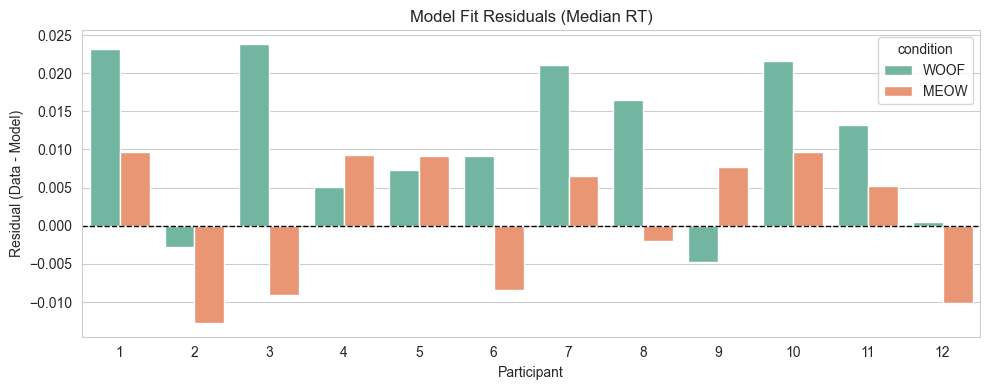


Mean absolute residual: 0.010s


In [17]:
residuals = []

for pid in participants:
    for cond in ["WOOF", "MEOW"]:
        df_sub = data_sub[pid][cond]
        correct_rts = df_sub[df_sub["choice"] == 1]["rt"].values
        
        if len(correct_rts) < 5:
            continue
        
        emp_median = np.median(correct_rts)
        
        params = {
            "drift": df_params.loc[df_params["participant"] == pid, f"drift_{cond}"].values[0],
            "B": df_params.loc[df_params["participant"] == pid, f"B_{cond}"].values[0],
            "nondectime": df_params.loc[df_params["participant"] == pid, f"nondectime_{cond}"].values[0],
        }
        
        model = build_fitted_model(params)
        solution = model.solve()
        t_domain = solution.model.t_domain()
        model_cdf = np.cumsum(solution.pdf("correct")) * solution.model.dt
        model_median = np.interp(0.5, model_cdf / model_cdf[-1], t_domain)
        
        residuals.append({
            'participant': pid,
            'condition': cond,
            'residual': emp_median - model_median
        })

df_residuals = pd.DataFrame(residuals)

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=df_residuals, x='participant', y='residual', hue='condition', ax=ax, palette='Set2')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_ylabel('Residual (Data - Model)')
ax.set_xlabel('Participant')
ax.set_title('Model Fit Residuals (Median RT)')
plt.tight_layout()
plt.show()

print(f"\nMean absolute residual: {np.abs(df_residuals['residual']).mean():.3f}s")

The Q-Q plots show the model fits very well (R² > 0.98). The points are close to the diagonal line, which means our predictions match the actual data.

<h2 style='color: #2E86AB'>Conclusion</h2>

Priming mainly affects boundary (how careful people are) and non-decision time (perception speed), not drift (evidence accumulation). The models fit well, so DDM is a good way to understand what's happening in this task.